In [1]:
#! /usr/bin/env python
import matplotlib.pyplot as plt
from quilt.data.uciml import iris
from quilt.data.uciml import wine_quality
from quilt.data.uciml import car
from quilt.data.uciml import abalone
from quilt.data.uciml import breast_cancer_wisconsin
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, LabelEncoder,LabelBinarizer
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import tree
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import cycle
import time

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def preprocessing(df):
    '''creates labels df and removes lables from original df'''
    df_labels=df['class']
    df_labels=df_labels.sort_values()
    labels=set(df_labels.values.tolist())
    label_encoded=encode(df_labels)
    encoding_mapping=dict(zip(label_encoded.values.ravel(),df_labels.values.ravel()))
    df=df.drop('class' ,1)

    return df,label_encoded,encoding_mapping

def encode(Y):
    ''' checks if labels are strings, and if they are they are encoded.in case we need to transform labels later'''
    #labels=Y['class'].values.tolist()
    encoder= LabelEncoder()
    encoded_labels=pd.Series(encoder.fit_transform(Y), index=Y.index)
    return encoded_labels


def split_data(X,Y,splits=1):
    split=StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)
    for train_index, valid_index in split.split(X, Y):
        X_train, X_valid=X.iloc[train_index], X.iloc[valid_index]
        Y_train, Y_valid=Y.iloc[train_index], Y.iloc[valid_index]
    # if splits==1:
    return X_train, X_valid,Y_train,Y_valid
    # else:
    #     yield X_train, X_valid,Y_train,Y_valid

In [3]:
class Classifier():
    def __init__(self,X_train,X_test,Y_train,Y_test,encoding=None,kfolds=5, neighbors=3,binarize=False,out=None):
        self.binarize=binarize
        self.out=out
        self.X_train = X_train
        self.X_test = X_test

        self.encoding_mapping=encoding#useful for plots
        self.n_classes = len(Y_train.drop_duplicates())
        self.classes=Y_train.drop_duplicates()
        
        if binarize: #likely to be used for the neural net
            self.Y_train= label_binarize(Y_train, classes=list(self.n_classes))
            self.Y_test= label_binarize(Y_test, classes=list(self.n_classes))
        else:
            self.Y_train=Y_train.values.ravel()
            self.Y_test=Y_test.values.ravel()
   
        
        self.kfolds = int(kfolds) #number of splits for cross validation
        self.neighbors = np.arange(1,neighbors,1)

    def linear_svc(self):
        model = LinearSVC(multi_class='crammer_singer',random_state=42,tol=1e-5).fit(self.X_train, self.Y_train)

        prediction=model.predict(self.X_test)
        score=model.score(self.X_test, self.Y_test)
        conf_scores=model.decision_function(self.X_test)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%score)
        print('confusion matrix \n',conf_matrix,'\n')
        self.plot_confusion(conf_matrix,out=self.out+'_Linear_SVC_confusion.png')
        self.plot_ROC(conf_scores,out=self.out+'_Linear_SVC_ROC.png',title=self.out+'_Linear_SVC Multiclass ROC')
    
    def svm_cv(self):
        starttime=time.time()
        param_dict = dict(C=np.linspace(1,10000,10), kernel=['poly', 'rbf'])
        model = SVC(random_state=42,tol=1e-5)
        
        print('running gridsearch with 10fold CV...')
        grid = GridSearchCV(model, param_grid=param_dict, cv=self.kfolds, refit=False)
        grid_fit = grid.fit(self.X_train, self.Y_train)
        end_time=time.time()-starttime
        print('finished grid search in %f seconds'%end_time)

        # summarize results
        print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))

        #refitting model with best params
        print('refitting model with best params...')
        C=grid_fit.best_params_['C']
        kernel=grid_fit.best_params_['kernel']

        #refitting with whole training set
        model = SVC(random_state=42,tol=1e-5,C=C, kernel=kernel).fit(self.X_train, self.Y_train)
        prediction=model.predict(self.X_test)
        conf_scores=model.decision_function(self.X_test)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%model.score(self.X_test, self.Y_test))
        self.plot_confusion(conf_matrix,out=self.out+'_SVM_%s_confusion.png'%kernel)
        self.plot_ROC(conf_scores,out=self.out+'_SVM_%s_ROC.png'%kernel,title=self.out+'_SVM_%s Multiclass ROC'%kernel)
    
    def lda(self):
        model = LinearDiscriminantAnalysis().fit(self.X_train, self.Y_train)
        prediction=model.predict(self.X_test)
        probabilities=model.predict_proba(self.X_test)
        acc_score=accuracy_score(self.Y_test,prediction)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%acc_score)
        print('confusion matrix \n',conf_matrix,'\n')
        self.plot_confusion(conf_matrix,out=self.out+'_LDA_confusion.png')
        self.plot_ROC(probabilities,out=self.out+'_LDA_ROC.png',title=self.out+'_LDA Multiclass ROC')

    def qda(self):
        model = QuadraticDiscriminantAnalysis().fit(self.X_train, self.Y_train)
        prediction=model.predict(self.X_test)
        probabilities=model.predict_proba(self.X_test)
        acc_score=accuracy_score(self.Y_test,prediction)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%acc_score)
        print('confusion matrix \n',conf_matrix,'\n')
        self.plot_confusion(conf_matrix,out=self.out+'_QDA_confusion.png')
        self.plot_ROC(probabilities,out=self.out+'_QDA_ROC.png',title=self.out+'_QDA Multiclass ROC')

    def dt(self):
        model = tree.DecisionTreeClassifier().fit(self.X_train, self.Y_train)
        prediction=model.predict(self.X_test)
        probabilities=model.predict_proba(self.X_test)
        acc_score=accuracy_score(self.Y_test,prediction)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%acc_score)
        print('confusion matrix \n',conf_matrix,'\n')
        self.plot_confusion(conf_matrix,out=self.out+'_DecisionTree_confusion.png')
        self.plot_ROC(probabilities,out=self.out+'_DT_ROC.png',title=self.out+'_Decision Tree Multiclass ROC')

    def lr(self):
        print('using one predictor at a time:')
        predictor_acc=dict()
        for predictor in self.X_train.columns:
            one_pred = OneVsRestClassifier(LogisticRegression(random_state=42,multi_class='multinomial',solver='lbfgs',max_iter=4000)).fit(self.X_train[[predictor]], self.Y_train)
            probabilities=one_pred.predict_proba(self.X_test[[predictor]])
            prediction=one_pred.predict(self.X_test[[predictor]])
            acc_score=accuracy_score(self.Y_test,prediction)
            #conf_matrix=confusion_matrix(self.Y_test,prediction)
            predictor_acc[predictor]=acc_score
            ##future updates do ROC for each predictor
        predictor_score=sorted(predictor_acc.items(), key=lambda x:x[1])

        print('top two predictors: ')
        for i in predictor_score[-2:]:
            print(i[0],'accuracy:',i[1])

        print('using all predictors:')
        model = OneVsRestClassifier(LogisticRegression(random_state=42,multi_class='multinomial',solver='lbfgs',max_iter=4000)).fit(self.X_train, self.Y_train)
        probabilities=model.predict_proba(self.X_test) #can be used in the roc curve
        prediction=model.predict(self.X_test)

        acc_score=accuracy_score(self.Y_test,prediction)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%acc_score)
        print('confusion matrix \n',conf_matrix,'\n')
        self.plot_confusion(conf_matrix,out=self.out+'_LR_confusion.png')
        self.plot_ROC(probabilities,out=self.out+'_LR_ROC.png',title=self.out+'_Logistic Regression Multiclass ROC')
        #print(model.scores_)

    def lrcv(self):
        model = LogisticRegressionCV(cv=self.kfolds, random_state=42,multi_class='multinomial',max_iter=4000).fit(self.X_train, self.Y_train)
        probabilities=model.predict_proba(self.X_test)
        prediction=model.predict(self.X_test)
        acc_score=accuracy_score(self.Y_test,prediction)
        conf_matrix=confusion_matrix(self.Y_test,prediction)

        print('accuracy %f'%acc_score)
        print('confusion matrix \n',conf_matrix)

    def knn(self):
        cv_acc=[]
        for k in self.neighbors:
            model= KNeighborsClassifier(n_neighbors=k)
            score=cross_val_score(model,self.X_train, self.Y_train, cv=10, scoring='accuracy')
            cv_acc.append(score.mean())
        MSE=[1-x for x in cv_acc]
        optimal_k=self.neighbors[MSE.index(min(MSE))]
        print('optimal k is:',optimal_k)
        optimal_model= KNeighborsClassifier(n_neighbors=optimal_k).fit(self.X_train,self.Y_train)
        probabilities=optimal_model.predict_proba(self.X_test)
        prediction=optimal_model.predict(self.X_test)
        acc_score=accuracy_score(self.Y_test,prediction)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%acc_score)
        print('confusion matrix \n',conf_matrix)
        self.plot_confusion(conf_matrix,out=self.out+'_KNN_confusion.png')
        self.plot_ROC(probabilities,out=self.out+'_KNN_ROC.png',title=self.out+'_KNN Multiclass ROC')

        fig = plt.gcf()
        fig.set_size_inches(10,10)
        ax = plt.axes()
        plt.plot(self.neighbors, MSE)
        plt.xlabel('Number of Neighbors K')
        plt.ylabel('Misclassification Error')
        plt.title(self.out+' MSE vs K', fontsize=10)
        plt.savefig(self.out+'_MSEvsk.png')
        plt.show()
        plt.close()
        #print(model.score)

    def rf_cv(self):
        starttime=time.time()
        model = RandomForestClassifier()
        param_dict = dict(max_depth=[3, 4],
                  bootstrap=[True, False],
                  criterion= ["gini", "entropy"], n_estimators=[10,20,30,40],min_samples_split= [2, 3, 10])
        grid = GridSearchCV(model, param_grid=param_dict, cv=self.kfolds, refit=False)

         #searching best params with cv
        print('running grid search...')
        grid_fit = grid.fit(self.X_train, self.Y_train)
        end_time=time.time()-starttime
        print('finished grid search in %f seconds'%end_time)

        # summarize results
        print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))

        #refitting model with best params
        print('refitting model with best params...')
        max_depth=grid_fit.best_params_['max_depth']
        bootstrap=grid_fit.best_params_['bootstrap']
        criterion=grid_fit.best_params_['criterion']
        n_estimators=grid_fit.best_params_['n_estimators']
        min_samples_split=grid_fit.best_params_['min_samples_split']
        
        #refitting with whole training set
        model = RandomForestClassifier(max_depth=max_depth, bootstrap=bootstrap, criterion=criterion, n_estimators=n_estimators, min_samples_split=min_samples_split).fit(self.X_train, self.Y_train)
        prediction=model.predict(self.X_test)
        predict_probability=model.predict_proba(self.X_test)
        conf_matrix=confusion_matrix(self.Y_test,prediction)
        print('accuracy %f'%model.score(self.X_test, self.Y_test))
        self.plot_confusion(conf_matrix,out=self.out+'_RandomForest_confusion.png')
        self.plot_ROC(predict_probability,out=self.out+'_RandomForest_ROC.png',title=self.out+'_RandomForest Multiclass ROC')
    
    def plot_confusion(self,conf_matrix, labels=None,out=None):
        fig = plt.gcf()
        fig.set_size_inches(10,10)
        ax = plt.axes()
        if labels is None:
            labels=range(conf_matrix.shape[0])
        labels=[self.encoding_mapping[label] for label in labels]
        df_cm = pd.DataFrame(conf_matrix, index=labels,
                      columns=labels)
        sns.set(font_scale=3)#for label size
        conf_hm=sns.heatmap(df_cm, annot=True,annot_kws={"size":30 })# font size
        fig=conf_hm.get_figure()
        plt.title(out, fontsize=10)
        fig.savefig(out,dpi=300)
        plt.show()
        plt.close()

    @staticmethod
    def plot_loss(losses, title=None):
        fig = plt.gcf()
        gene=title.split(' ')[0]
        fig.set_size_inches(10,10)
        ax = plt.axes()
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        x_loss = list(range(len(losses)))
        plt.plot(x_loss, losses, color='red', label='Loss')
        plt.legend(loc='upper right',prop={'size': 10})
        plt.title(title, fontsize=10)
        plt.savefig('LossPlot.png',dpi=300)
        plt.show()
        plt.close()

    @staticmethod
    def plot_accuracy(accuracies, title=None):
        fig = plt.gcf()
        fig.set_size_inches(10,10)
        ax = plt.axes()
        ax.set_xlabel("Iteration")
        ax.set_ylabel("accuracy")
        x_loss = list(range(len(accuracies)))
        plt.plot(x_loss, accuracies, color='blue', label='Accuracy')
        plt.legend(loc='upper right',prop={'size': 10})
        plt.title(title, fontsize=10)
        plt.savefig('AccuracyPlot.png',dpi=300)
        plt.show()
        plt.close()

    def plot_ROC(self,classes_scores, title='ROC plot',out='ROCplot.png'):
        if self.binarize:
            Y_test=self.Y_test
        else:
            Y_test=label_binarize(self.Y_test, classes=np.arange(0,self.n_classes,1))

        fig = plt.gcf()
        fig.set_size_inches(10,10)
        ax = plt.axes()

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(self.n_classes):
            fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], classes_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        colors = ['aqua', 'darkorange', 'cornflowerblue']
        lw=4
        for i, color in zip(range(self.n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(self.encoding_mapping[i], roc_auc[i]))
        ax.grid(False)

        ax.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.03, 1.05])
        plt.ylim([-0.03, 1.05])
        plt.xlabel('False Positive Rate', fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title(title, fontsize=10)
        plt.legend(loc="lower right",prop={'size': 10})
        plt.savefig(out,dpi=300)
        plt.show()
        plt.close()

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
logistic regression results for iris:
using one predictor at a time:
top two predictors: 
petal_width accuracy: 0.9
petal_length accuracy: 0.9666666666666667
using all predictors:
accuracy 0.933333
confusion matrix 
 [[10  0  0]
 [ 0  8  2]
 [ 0  0 10]] 



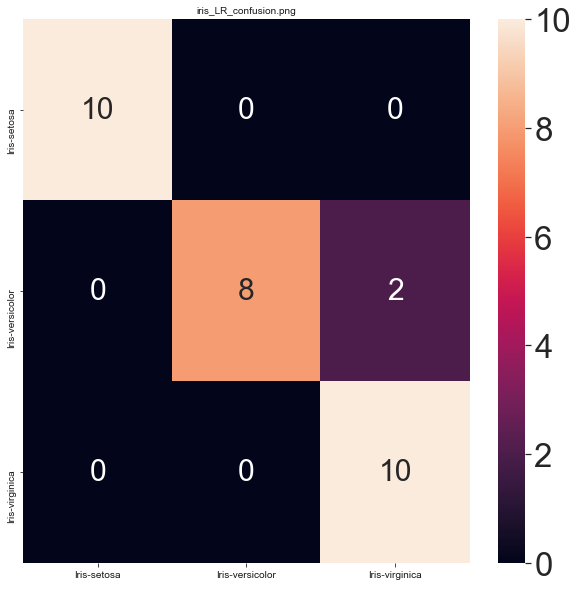

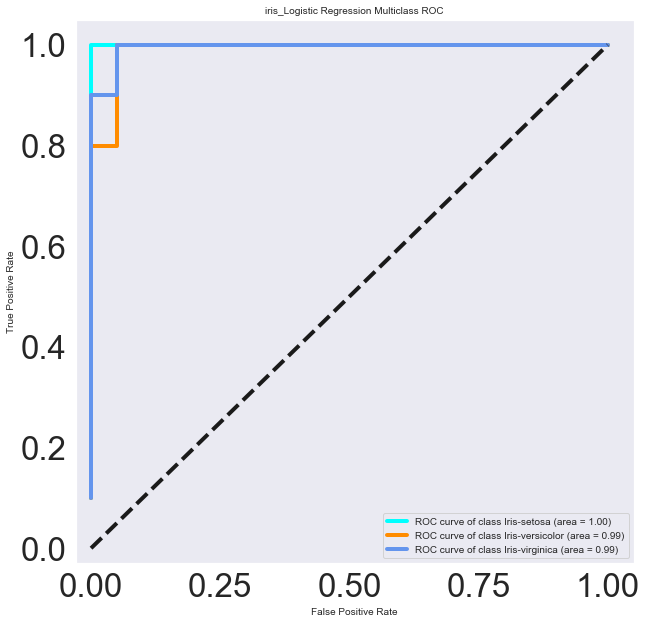

KNN results for iris:
optimal k is: 5
accuracy 1.000000
confusion matrix 
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


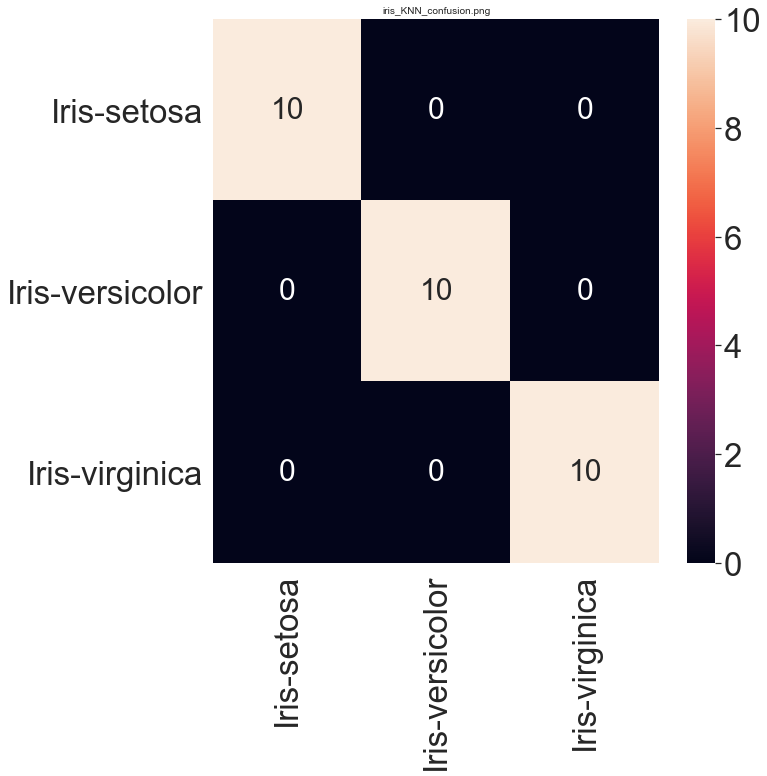

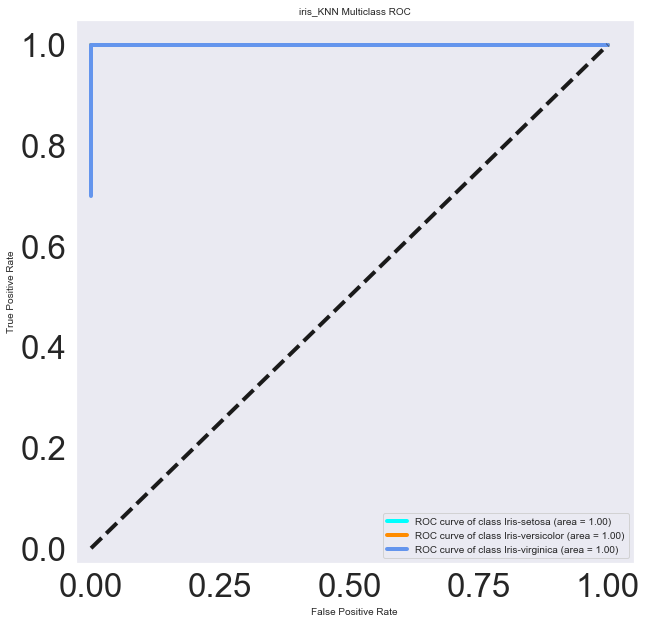

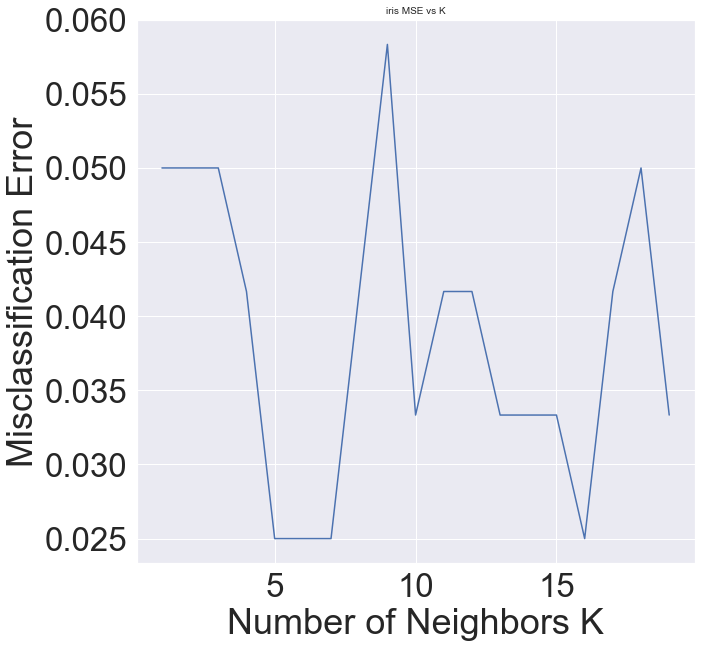

LDA results for iris:
accuracy 1.000000
confusion matrix 
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]] 



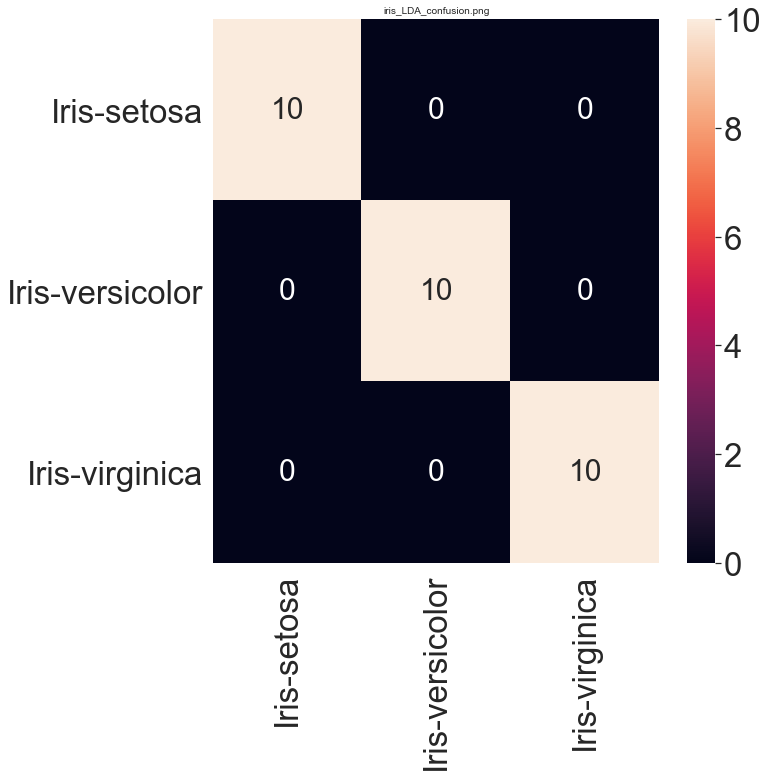

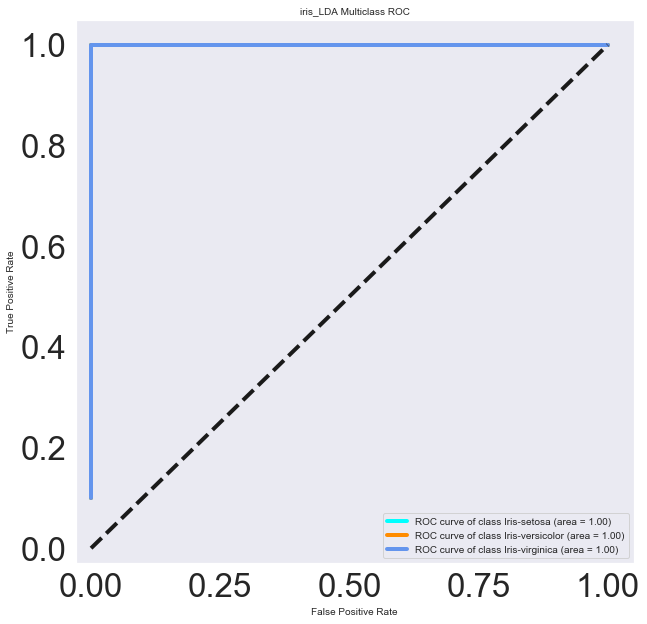

QDA results for iris:
accuracy 1.000000
confusion matrix 
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]] 



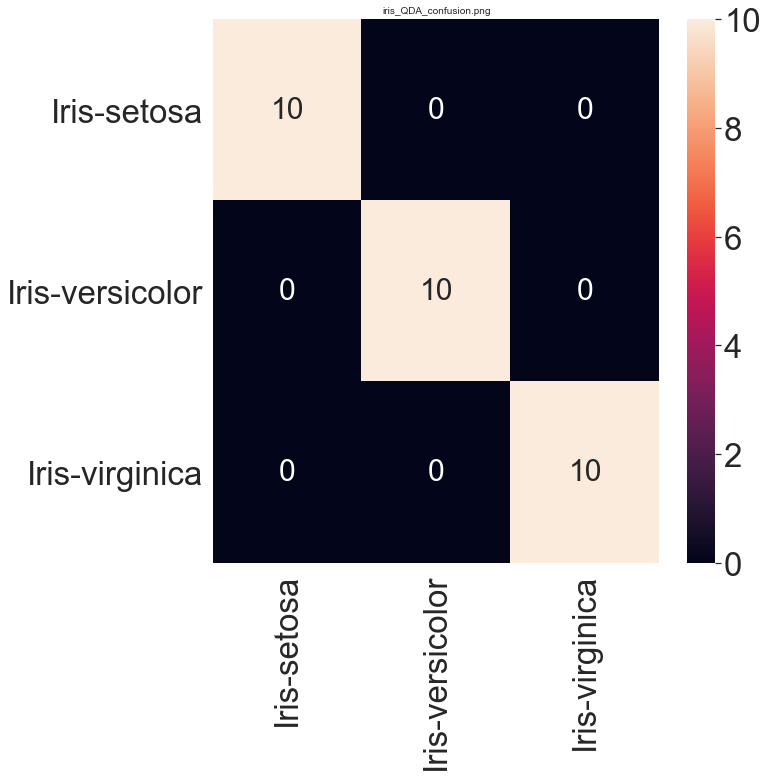

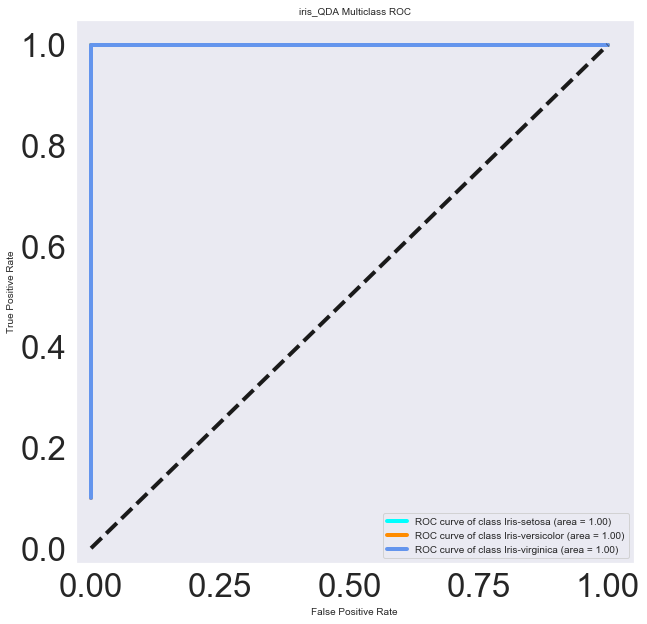

Decision Tree results for iris:
accuracy 0.966667
confusion matrix 
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]] 



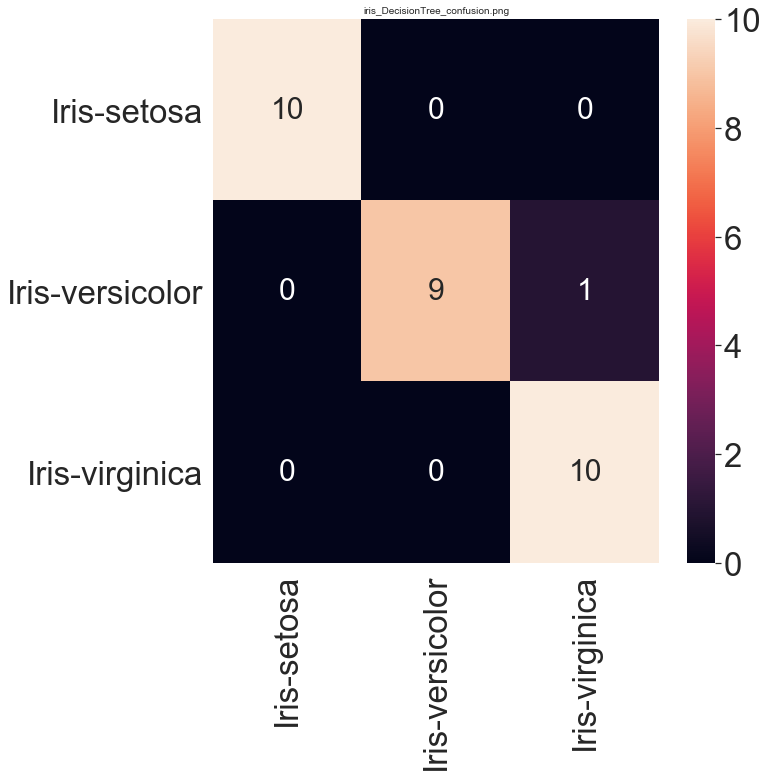

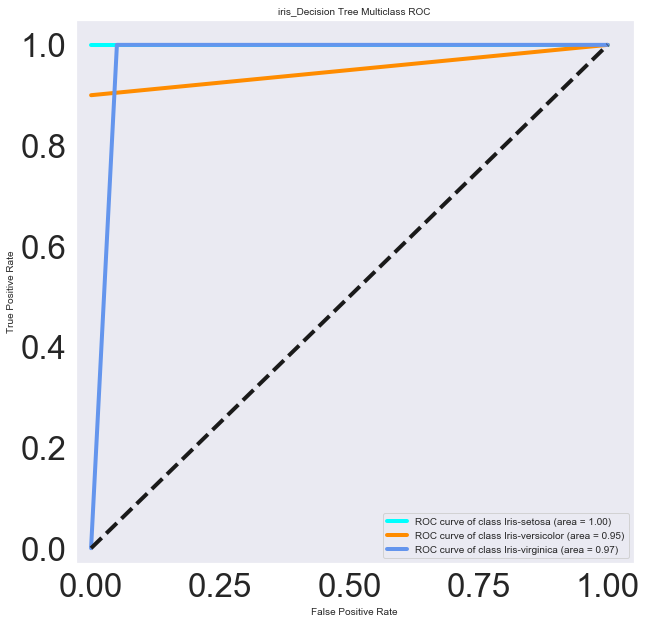

Linear SVC results for iris:
accuracy 1.000000
confusion matrix 
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]] 



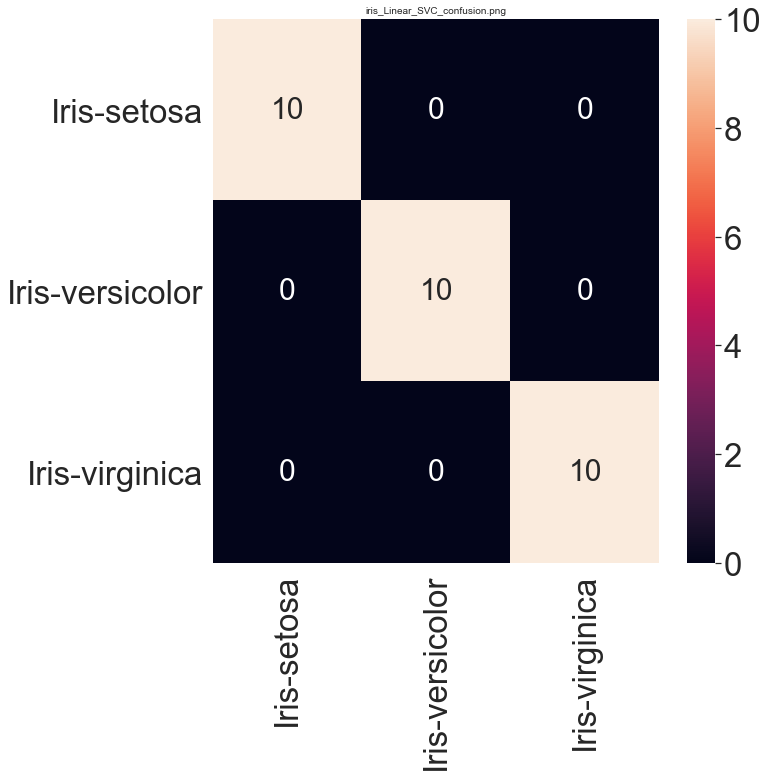

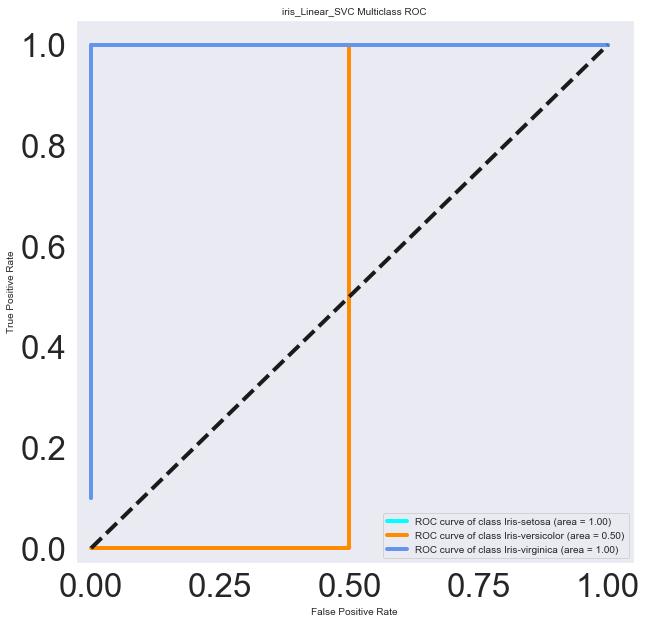

Random Forest results for iris:
running grid search...
finished grid search in 9.196806 seconds
Best: 0.975000 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 10}
refitting model with best params...
accuracy 0.933333


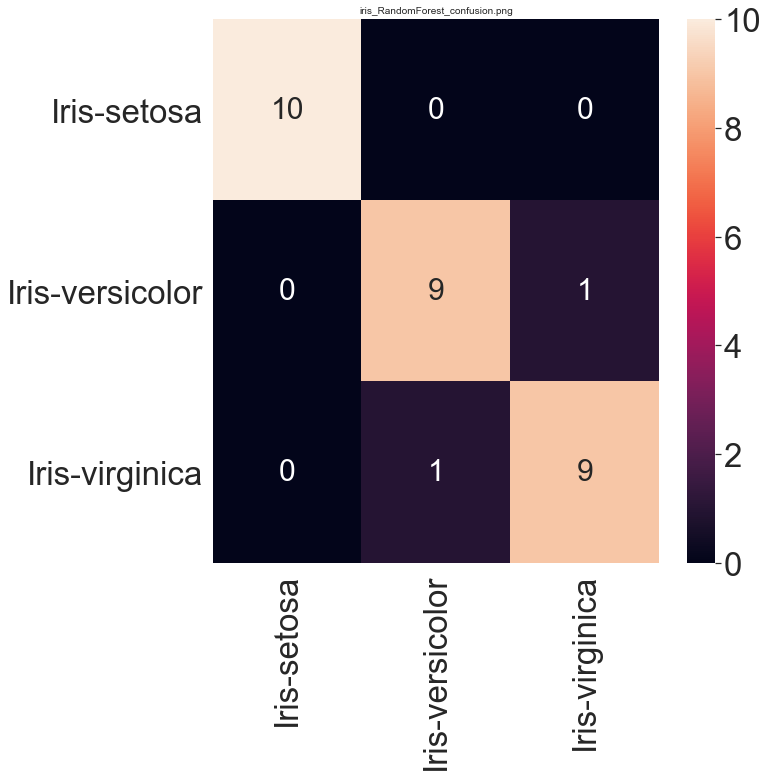

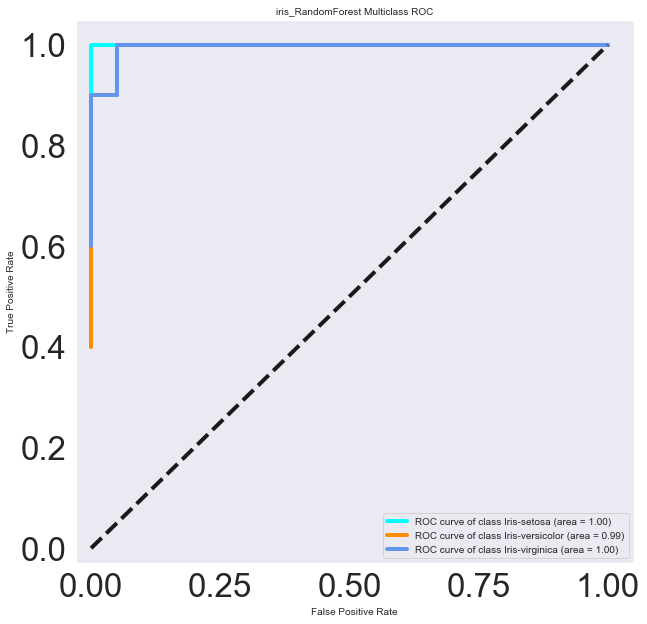

SVM CV results for iris:
running gridsearch with 10fold CV...
finished grid search in 3.536845 seconds
Best: 0.983333 using {'C': 1.0, 'kernel': 'rbf'}
refitting model with best params...
accuracy 0.966667


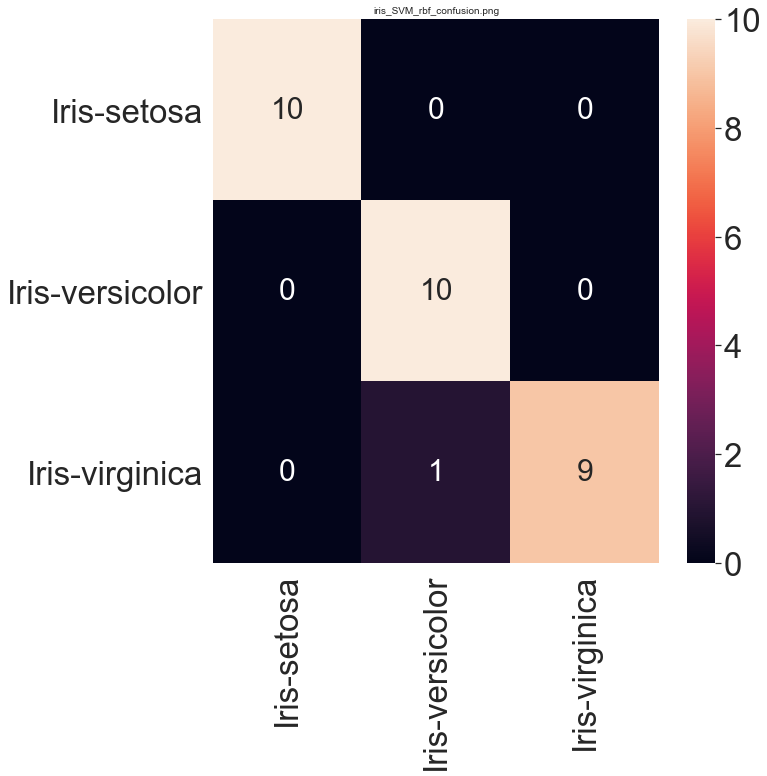

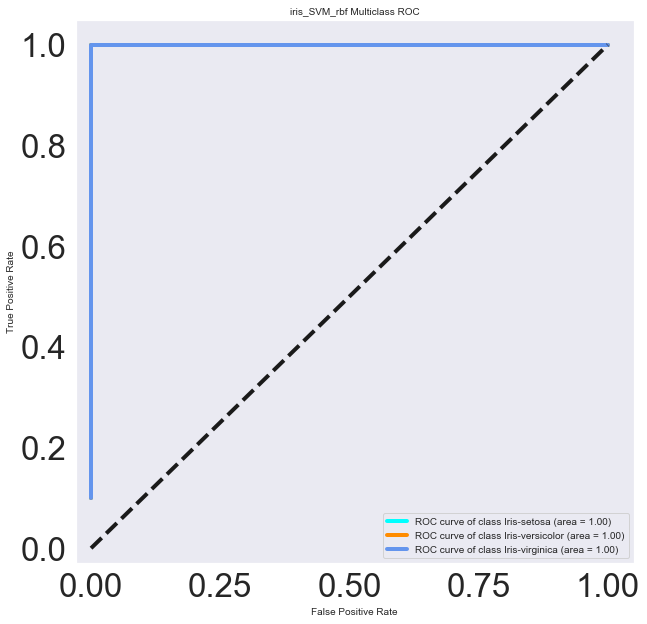

{0: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 8}
logistic regression results for wine:
using one predictor at a time:
top two predictors: 
alcohol accuracy: 0.471875
fixed acidity accuracy: 0.475
using all predictors:
accuracy 0.509375
confusion matrix 
 [[ 0  0  2  0  0  0]
 [ 0  0  7  3  1  0]
 [ 0  0 95 40  1  0]
 [ 0  0 62 65  1  0]
 [ 0  0 10 27  3  0]
 [ 0  0  0  3  0  0]] 



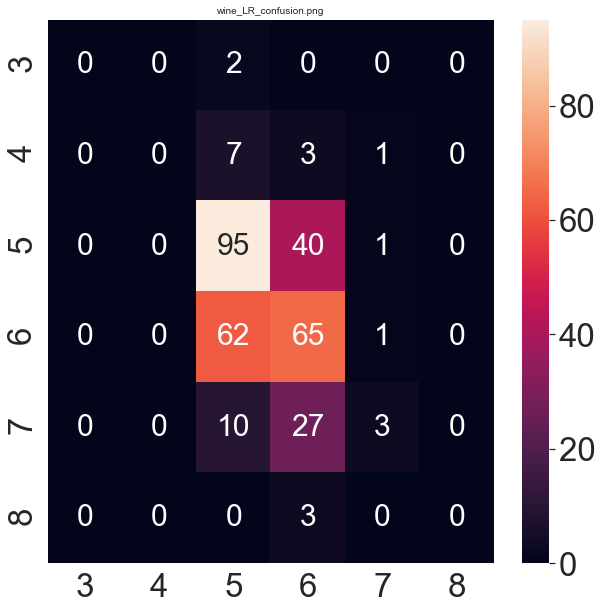

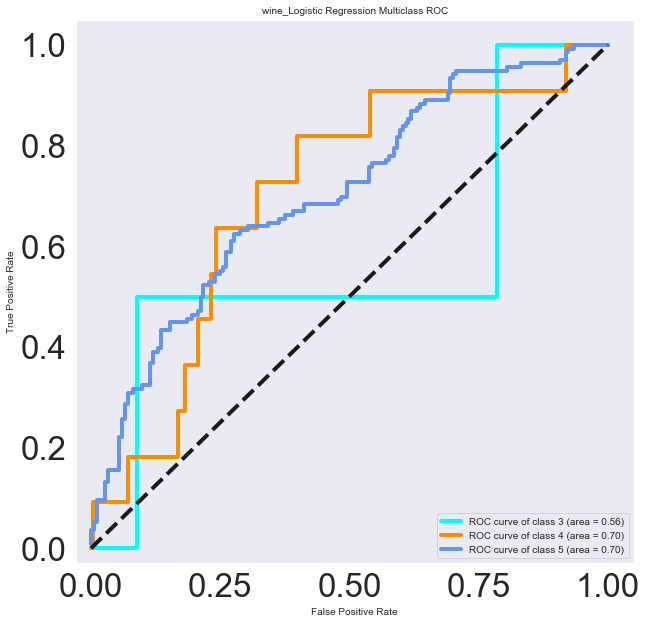

KNN results for wine:


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number 

optimal k is: 1
accuracy 0.593750
confusion matrix 
 [[ 0  0  0  1  1  0]
 [ 2  0  4  2  3  0]
 [ 0  5 90 27 14  0]
 [ 0  4 30 82 11  1]
 [ 0  0 13  9 18  0]
 [ 0  0  0  2  1  0]]


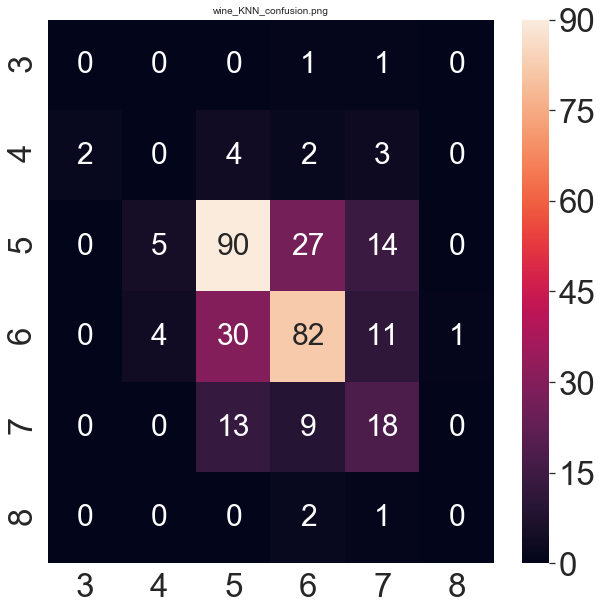

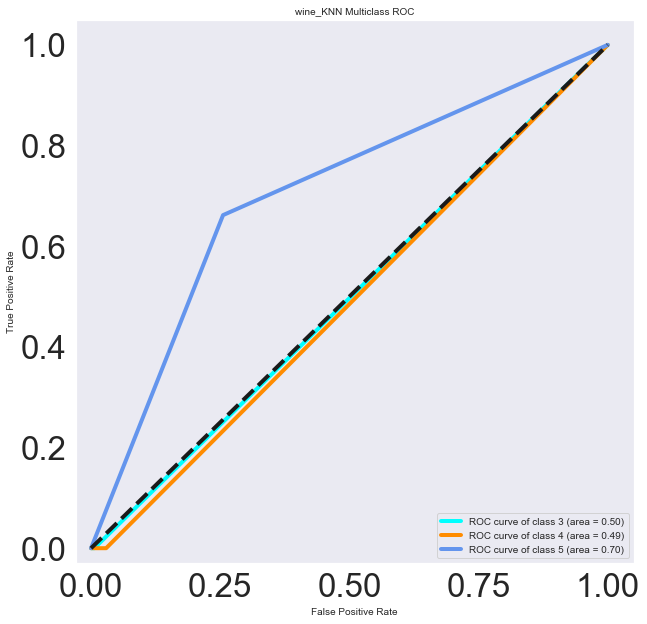

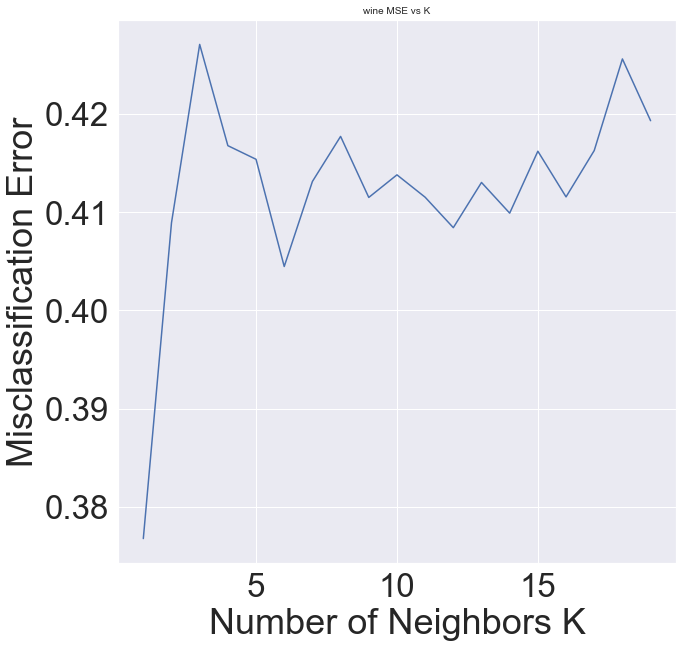

LDA results for wine:
accuracy 0.540625
confusion matrix 
 [[ 0  0  1  1  0  0]
 [ 0  0  6  4  1  0]
 [ 0  1 96 37  1  1]
 [ 0  2 48 71  6  1]
 [ 0  0 13 20  6  1]
 [ 0  0  0  2  1  0]] 



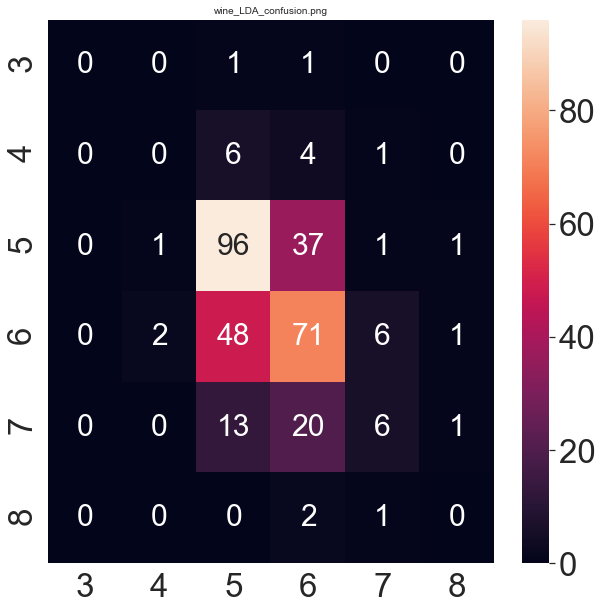

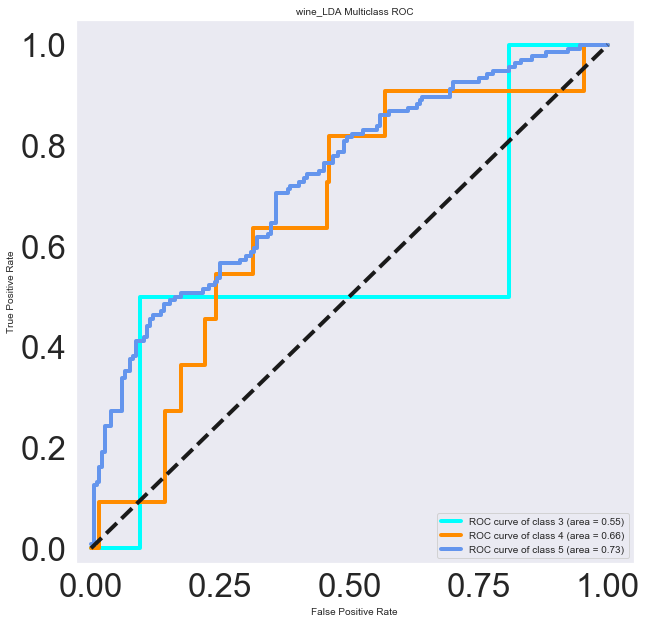

QDA results for wine:
accuracy 0.562500
confusion matrix 
 [[ 0  0  1  1  0  0]
 [ 0  0  4  6  1  0]
 [ 0  7 80 44  5  0]
 [ 0  4 29 82 13  0]
 [ 0  0  6 17 17  0]
 [ 0  0  0  1  1  1]] 



/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


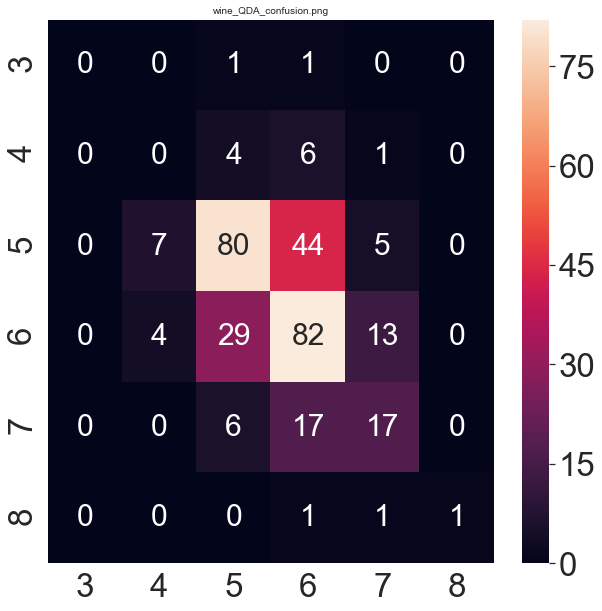

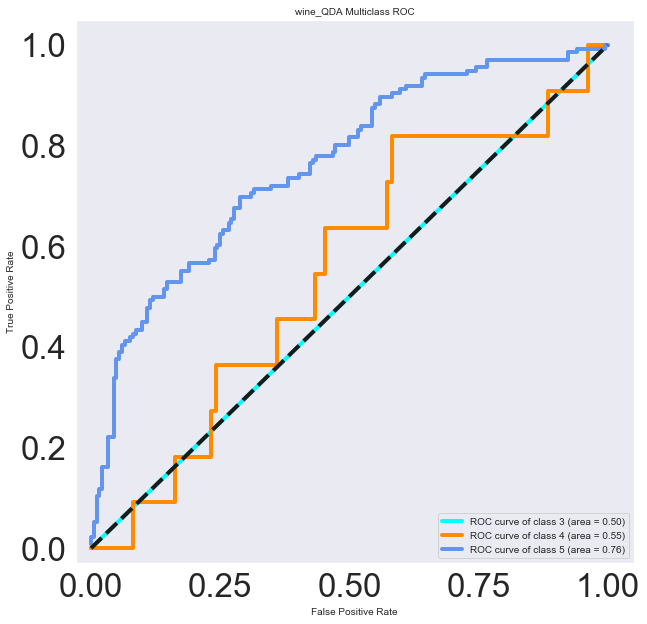

Decision Tree results for wine:
accuracy 0.628125
confusion matrix 
 [[ 0  1  1  0  0  0]
 [ 1  1  8  1  0  0]
 [ 0  6 89 33  8  0]
 [ 1  4 27 86 10  0]
 [ 0  0  4 11 25  0]
 [ 0  0  0  0  3  0]] 



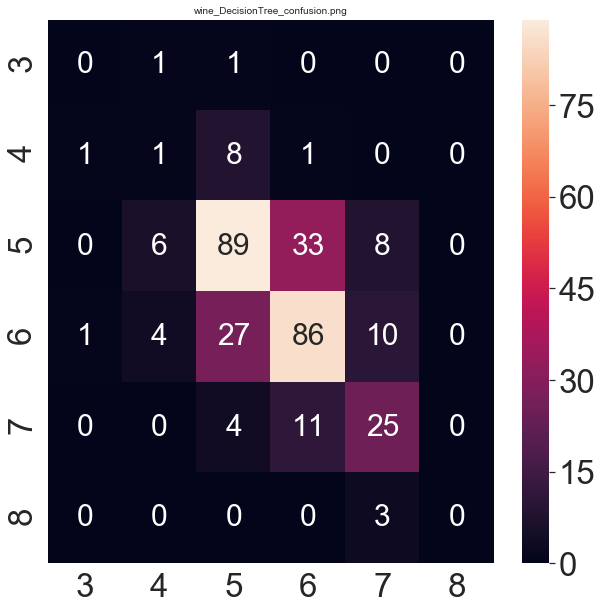

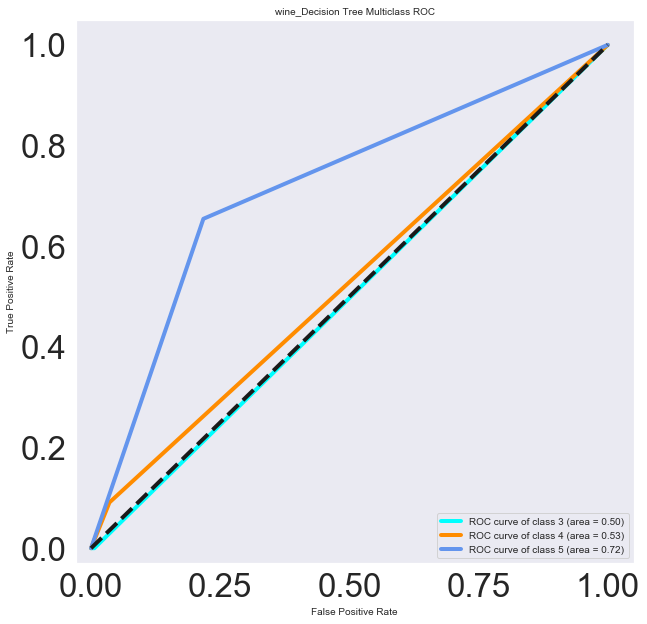

Linear SVC results for wine:
accuracy 0.509375
confusion matrix 
 [[ 0  0  1  1  0  0]
 [ 1  0  5  5  0  0]
 [ 0  0 96 40  0  0]
 [ 0  0 60 67  1  0]
 [ 0  0 18 22  0  0]
 [ 0  0  0  3  0  0]] 



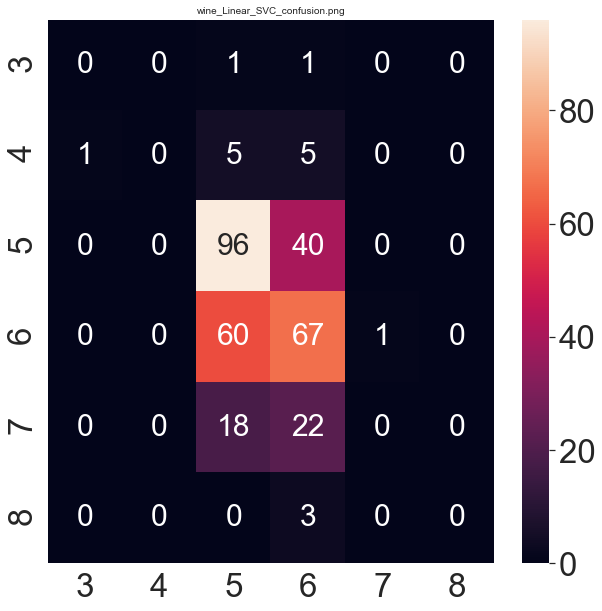

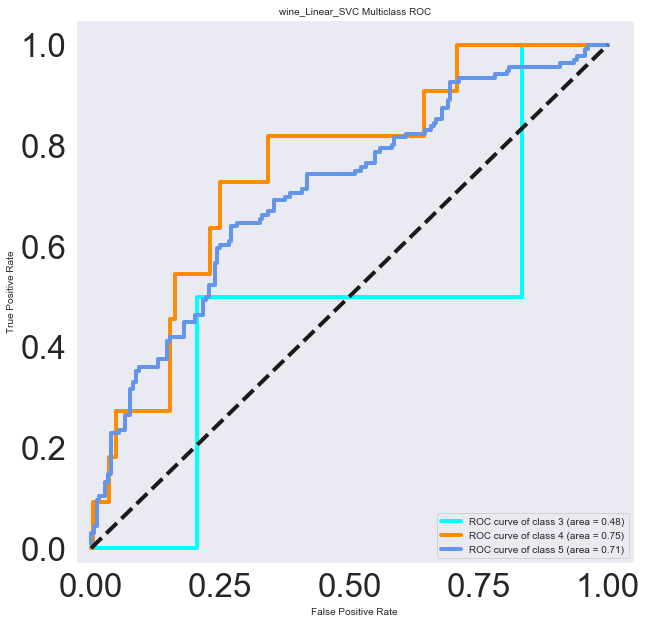

Random Forest results for wine:
running grid search...
finished grid search in 15.355598 seconds
Best: 0.635653 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 20}
refitting model with best params...
accuracy 0.543750


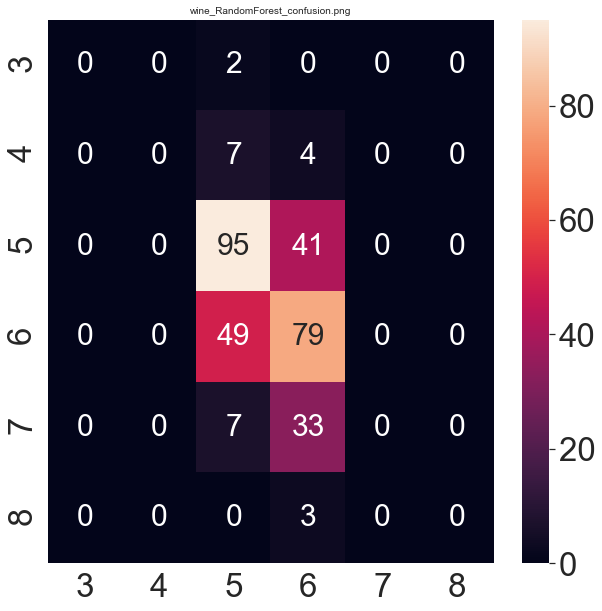

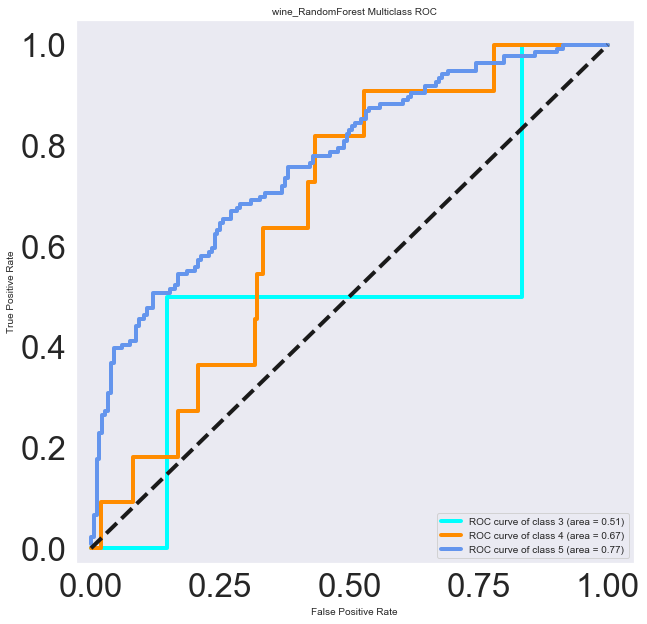

SVM CV results for wine:
running gridsearch with 10fold CV...


In [ ]:
iris=iris.tables.iris()
wine=wine_quality.tables.red()
wine=wine.rename(index=str, columns={"quality": "class"}) #keeping class column label the same across
abalone=abalone.tables.abalone()
abalone=abalone.rename(index=str, columns={'Sex':'class'})
for c in abalone.columns:
    abalone=abalone.rename(index=str, columns={c:c.lower().replace(' ','')})


datasets=[(iris,'iris'), (wine, 'wine'), (abalone, 'abalone')]
for dataset in datasets:
    out=dataset[1]

    X,Y,mapping=preprocessing(dataset[0]) 
    X_train, X_test,Y_train,Y_test=split_data(X,Y)
    print(mapping)
    classify=Classifier(X_train, X_test,Y_train,Y_test,encoding=mapping,kfolds=5, neighbors=20,out=out)
    
    print('logistic regression results for %s:' %out)
    classify.lr()
    print('KNN results for %s:' %out)
    classify.knn()
    print('LDA results for %s:' %out)
    classify.lda()
    print('QDA results for %s:' %out)
    classify.qda()
    print('Decision Tree results for %s:' %out)
    classify.dt()
    print('Linear SVC results for %s:' %out)
    classify.linear_svc()
    print('Random Forest results for %s:' %out)
    classify.rf_cv()
    print('SVM CV results for %s:' %out)
    classify.svm_cv()
